#### Let's look at another example of using distances and similarities. This time, we'll look at a hypothetical search engine index and see how we can use k-nearest-neighbor search to identify the documents that are most similar to a specified query. A similar approach can be used to find objects that are most similar to a specified object in other domains.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### In our data set, we have 15 documents. We assume that the documents have already been preprocessed, converted into word vectors (bags of words), and inserted into an index. After preprocessing and removing "stop words" we are left with 10 index terms (used as dimensions for the document vectors). 

In [2]:
DF = pd.read_csv("http://facweb.cs.depaul.edu/mobasher/classes/csc478/data/term-doc-mat.csv", header=None)
DF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,database,24,32,12,6,43,2,0,3,1,6,4,0,0,0,0
1,index,9,5,5,2,20,0,1,0,0,0,27,14,3,2,11
2,likelihood,0,3,0,0,3,7,12,4,27,4,0,1,0,0,0
3,linear,3,0,0,0,0,16,0,2,25,23,7,12,21,3,2
4,matrix,1,0,0,0,0,33,2,0,7,12,14,5,12,4,0
5,query,12,2,0,0,27,0,0,0,0,22,9,4,0,5,3
6,regression,0,0,0,0,0,18,32,22,34,17,0,0,0,0,0
7,retrieval,1,0,0,0,2,0,0,0,3,9,27,7,5,4,4
8,sql,21,10,16,7,31,0,0,0,0,0,0,0,0,1,0
9,vector,2,0,0,2,0,27,4,2,11,8,33,16,14,7,3


#### Let's remove the column containing the terms

In [3]:
# TD will be the termxdocument matrix
TD = DF.iloc[:,1:]
TD

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,24,32,12,6,43,2,0,3,1,6,4,0,0,0,0
1,9,5,5,2,20,0,1,0,0,0,27,14,3,2,11
2,0,3,0,0,3,7,12,4,27,4,0,1,0,0,0
3,3,0,0,0,0,16,0,2,25,23,7,12,21,3,2
4,1,0,0,0,0,33,2,0,7,12,14,5,12,4,0
5,12,2,0,0,27,0,0,0,0,22,9,4,0,5,3
6,0,0,0,0,0,18,32,22,34,17,0,0,0,0,0
7,1,0,0,0,2,0,0,0,3,9,27,7,5,4,4
8,21,10,16,7,31,0,0,0,0,0,0,0,0,1,0
9,2,0,0,2,0,27,4,2,11,8,33,16,14,7,3


In [4]:
# Reindex the columns to start from 0
TD.columns= range(15)
TD

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,24,32,12,6,43,2,0,3,1,6,4,0,0,0,0
1,9,5,5,2,20,0,1,0,0,0,27,14,3,2,11
2,0,3,0,0,3,7,12,4,27,4,0,1,0,0,0
3,3,0,0,0,0,16,0,2,25,23,7,12,21,3,2
4,1,0,0,0,0,33,2,0,7,12,14,5,12,4,0
5,12,2,0,0,27,0,0,0,0,22,9,4,0,5,3
6,0,0,0,0,0,18,32,22,34,17,0,0,0,0,0
7,1,0,0,0,2,0,0,0,3,9,27,7,5,4,4
8,21,10,16,7,31,0,0,0,0,0,0,0,0,1,0
9,2,0,0,2,0,27,4,2,11,8,33,16,14,7,3


In [5]:
# The list of our index terms
terms = DF.iloc[:,0]
terms

0      database
1         index
2    likelihood
3        linear
4        matrix
5         query
6    regression
7     retrieval
8           sql
9        vector
Name: 0, dtype: object

#### Transposing the TD matrix.

In [6]:
DT = TD.T

#### Now we have a document-term matrix:

In [7]:
DT

,0,1,2,3,4,5,6,7,8,9
0,24,9,0,3,1,12,0,1,21,2
1,32,5,3,0,0,2,0,0,10,0
2,12,5,0,0,0,0,0,0,16,0
3,6,2,0,0,0,0,0,0,7,2
4,43,20,3,0,0,27,0,2,31,0
5,2,0,7,16,33,0,18,0,0,27
6,0,1,12,0,2,0,32,0,0,4
7,3,0,4,2,0,0,22,0,0,2
8,1,0,27,25,7,0,34,3,0,11
9,6,0,4,23,12,22,17,9,0,8


In [8]:
DT.shape

(15, 10)

In [9]:
numTerms=DT.shape[1]
NDocs = DT.shape[0]

In [10]:
print(numTerms)
print(NDocs)

10
15


#### Next, let's compute term frequencies to get an idea of their distributions across the corpus.

In [11]:
termFreqs = TD.sum(axis=1)
print(termFreqs)

0    133
1     99
2     61
3    114
4     90
5     84
6    123
7     62
8     86
9    129
dtype: int64


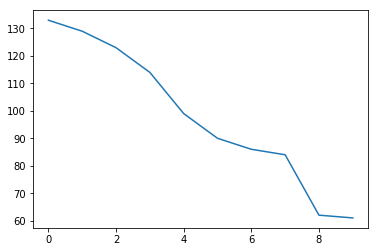

In [12]:
plt.plot(sorted(termFreqs, reverse=True))
plt.show()

#### We convert the dataframe into a Numpy array which will be used as input for our search function.

In [13]:
DTM = np.array(DT)
DTM

array([[24,  9,  0,  3,  1, 12,  0,  1, 21,  2],
       [32,  5,  3,  0,  0,  2,  0,  0, 10,  0],
       [12,  5,  0,  0,  0,  0,  0,  0, 16,  0],
       [ 6,  2,  0,  0,  0,  0,  0,  0,  7,  2],
       [43, 20,  3,  0,  0, 27,  0,  2, 31,  0],
       [ 2,  0,  7, 16, 33,  0, 18,  0,  0, 27],
       [ 0,  1, 12,  0,  2,  0, 32,  0,  0,  4],
       [ 3,  0,  4,  2,  0,  0, 22,  0,  0,  2],
       [ 1,  0, 27, 25,  7,  0, 34,  3,  0, 11],
       [ 6,  0,  4, 23, 12, 22, 17,  9,  0,  8],
       [ 4, 27,  0,  7, 14,  9,  0, 27,  0, 33],
       [ 0, 14,  1, 12,  5,  4,  0,  7,  0, 16],
       [ 0,  3,  0, 21, 12,  0,  0,  5,  0, 14],
       [ 0,  2,  0,  3,  4,  5,  0,  4,  1,  7],
       [ 0, 11,  0,  2,  0,  3,  0,  4,  0,  3]], dtype=int64)

#### The search function takes a query object (in this case a vector of words), and searches for the K most similar (least distant) items in the data (our index of documents). The "measure" parameter allows us to use either the Euclidean distance or the inverse of Cosine similarity as our ditance metric. The function returns the indices of the K most similar neighbors and a list of their distances to the query object.

In [14]:
def knn_search(x, D, K, measure):
    """ find K nearest neighbors of an instance x among the instances in D """
    if measure == 0:
        # euclidean distances from the other points
        dists = np.sqrt(((D - x)**2).sum(axis=1))
    elif measure == 1:
        # first find the vector norm for each instance in D as wel as the norm for vector x
        D_norm = np.array([np.linalg.norm(D[i]) for i in range(len(D))])
        x_norm = np.linalg.norm(x)
        # Compute Cosine: divide the dot product o x and each instance in D by the product of the two norms
        sims = np.dot(D,x)/(D_norm * x_norm)
        # The distance measure will be the inverse of Cosine similarity
        dists = 1 - sims
    idx = np.argsort(dists) # sorting
    # return the indexes of K nearest neighbors
    return idx[:K], dists

#### Let's now try this on a new query object

In [15]:
x = np.array([3, 22, 0, 17, 9, 6, 1, 12, 0, 22])
x

array([ 3, 22,  0, 17,  9,  6,  1, 12,  0, 22])

In [16]:
# Finding the k=5 nearest neighbors using inverse of Cosine similarity as a distance metric
neigh_idx, distances = knn_search(x, DTM, 5, 1)

In [17]:
neigh_idx

array([11, 10, 13, 14, 12], dtype=int64)

In [18]:
distances = pd.Series(distances, index=DT.index)
distances

0     0.669527
1     0.836397
2     0.818826
3     0.718808
4     0.692761
5     0.386637
6     0.881295
7     0.877364
8     0.603925
9     0.400426
10    0.069511
11    0.007385
12    0.194400
13    0.152276
14    0.172249
dtype: float64

In [19]:
print("Query:", x)
print("\nNeighbors:")
DT.iloc[neigh_idx]

Query: [ 3 22  0 17  9  6  1 12  0 22]

Neighbors:


,0,1,2,3,4,5,6,7,8,9
11,0,14,1,12,5,4,0,7,0,16
10,4,27,0,7,14,9,0,27,0,33
13,0,2,0,3,4,5,0,4,1,7
14,0,11,0,2,0,3,0,4,0,3
12,0,3,0,21,12,0,0,5,0,14


In [20]:
# Finding the k=5 nearest neighbors using Euclidean distance metric
neigh_idx, distances = knn_search(x, DTM, 5, 0)

In [21]:
print(neigh_idx)

[11 10 12 14 13]


In [22]:
distances = pd.Series(distances, index=DT.index)
distances

0     43.231933
1     47.476310
2     40.755368
3     37.536649
4     63.007936
5     40.062451
6     48.959167
7     42.743421
8     51.107729
9     35.651087
10    22.516660
11    13.453624
12    23.345235
13    30.364453
14    29.512709
dtype: float64

In [23]:
print("Query:", x)
print("\nNeighbors:")
DT.iloc[neigh_idx]

Query: [ 3 22  0 17  9  6  1 12  0 22]

Neighbors:


,0,1,2,3,4,5,6,7,8,9
11,0,14,1,12,5,4,0,7,0,16
10,4,27,0,7,14,9,0,27,0,33
12,0,3,0,21,12,0,0,5,0,14
14,0,11,0,2,0,3,0,4,0,3
13,0,2,0,3,4,5,0,4,1,7


#### Note that the choice of the distance function made a difference in the ranking of the top neighbors (i.e., the top returned documents given the query).